# Tutorial - Estimating the Bias of a Coin


**[Internal] Credits**: Thos tutorial in its current form is developed jointly with Kinjal Shah and Feynman Liang, and with valuable input feedback provided by Eric Lippert, Nim Arora, David Noursi, Naz Tehrani, Narges Torabi, and Michael Tingley. The tutorial was based on Eric Lippert's Coin Example (N237192), who in turn had based it on an example provided by Naz and that apparently goes back to Nim (N140649). The tutorial also used ideas from Diagnostics tutorial by Narges (N184829).

The purpose of this tutorial to introduce some key elements of Bean Machine and
to illustrate a typical pattern for using them.

## Problem

In this tutorial we consider the problem of estimating the probability 
of heads for a potentially biased coin given a sample consisting of the result of tossing the same coin multiple times.

## Prerequisites

The Python code we present for our Bean Machine models should be executable if run in the order it appears. The packages required by the code are as follows:

In [31]:
from math import exp

import beanmachine.ppl as bm
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import torch
import torch.distributions as dist

## Model

We can view our problem as an instance of a Bayesian inference problem of estimating:

$$
P(coin\_bias\ |\ coin\_toss_{i=1..flip\_count})
$$

Solving this problem requires specifying a prior distribution for coin_bias and also the relation between coin_toss and coin_bias. We can do this as follows:

$$
\begin{array}{lcl}
flip\_count  & =    & \text{number of coin flips in our sample} \\
coin\_bias   & \sim & Beta(2,2) \\
coin\_toss_{i=1..flip\_count} & \sim & Bernoulli(coin\_bias)\\
\end{array}
$$


As a convention, we will consider an outcome of one (1) from the Bernoulli distribution to represent heads. Here we chose to use a Beta distribution for the prior distribution for the coin's probability of heads, but in principle any distribution over [0,1] can be used. The particular Beta distribution we use in this instance can be visualized as follows:

In [32]:
d = dist.Beta(2,2)

We can visualize this distribution as follows:

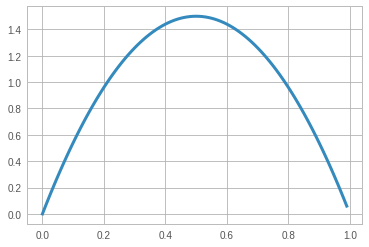

In [33]:
t = torch.arange(0.0, 1.0, 0.01)
plt.plot(t, [exp(float(d.log_prob(torch.tensor(i)))) for i in t], linewidth=3)
pass # Tip: See previous tip

Bean Machine allows us to write our models in Python in a manner that is very similar to the way that we expressed them mathematically above. For example, to introduce the random variable called `coin_bias()` described above we write the following:

In [34]:
@bm.random_variable
def coin_bias():
   return dist.Beta(2,2)

Decorating the definition of `coin_bias()` with `@bm.random_variable` tells Bean Machine
that we interpret this function as a random variable drawn from this particular distribution. 

The empty paramater list `()` in the definition above indicates that the sample that will be drawn from this variable is a single value drawn from that distribution rather than a vector or a matrix/tensor of samples. An important role for arguments to Bean Machine random variables is to indicate the vector dimensionality of the samples that we will draw from the distribution. In this case, the vector dimension is zero, meaning that the sample will consist of just one value.

For new users it is very helpful to keep in mind that
each definition that uses the `@bm.random_variable` decorator introduces a 
*unique* hypothetical element of the distribution that is referred to with
`coin_base()`. In particular, this term is not a randomly selected sample from that distribution. 
So, if we write `coin_bias() + coin_bias()`, this
is equivalent to writing `2 * coin_bias()` and not
to two different samples from the same distribution.

Now let us introduce the family of random variables called `coin_toss(i)`:

In [35]:
@bm.random_variable
def coin_toss(i):
    return dist.Bernoulli(coin_bias())

In contrast to the random variable `coin_bias()` introduced above, the family of random variable `coin_toss(i)` has a parameter `(i)`. Notice that this parameter is not used in the body of the definition: As noted above, an important role for parameters to random variables is to specify the vector dimensionality of the samples drawn from this distribution. If the variable is used in the body of the function, it means that the distribution can vary for different positions in the sample (family).

Having a vector dimensions of one for the samples that we will draw for each member of the family of random variable allows us to refer to the indvidual samples drawn from for different random variables. This allows us to refer to members of the family as `coin_toss(1)`, `coin_toss(2)`, and so on. These terms behave in a similar way to those for `coin_bias()` in that `coin_toss(1) + coin_toss(1)` is always equal to `2 * coin_toss(1)`. At the same time, `coin_toss(1)` and `coin_toss(2)` are in general not equal.

Bean Machine models can be packaged into Python classes and instantiated as needed. The following code illustrates how to do this:

In [44]:
class BiasedCoinModel(object):
    
    @bm.random_variable
    def coin_bias(self):
       return b

    @bm.random_variable
    def coin_toss(self,i):
       return dist.Bernoulli(self.coin_bias())

bcm = BiasedCoinModel()

Note that we need to make a few changes when top-level function definitions such as the above are moved into a class. In particular, we add `self` as an explicit parameter, and we refer to other variables defined in the same class we add the `self.` prefix.

## Observed Sample

To complete the Bean Machine description of our statistical inference problem 
we need to define the observation. In this case we will make our
observation on coin tosses. To get a sense of how well our inference
algorithm will work, we will use a synthetically generated sample. For the
purpose of having a reference point, we will create a synthetic 
observation that is generated by a Bernoulli distribution where the probability of heads is 0.75.

In [37]:
true_coin_bias = 0.75
coin_true_distribution = dist.Bernoulli(true_coin_bias)
flip_count = 100

Now we model flipping it a few times:

In [38]:
torch.manual_seed(42) # Explicitly seed for reproducibility
coin_data = [coin_true_distribution.sample() for i in range(flip_count)]
coin_observed_rate = sum(coin_data)/flip_count
print (f"Observed rate of heads: {coin_observed_rate*100.0}%")

Observed rate of heads: 71.0%


Our inference algorithms expect observations in the form of a dictionary.
This is easily accomplished as follows:

In [39]:
coin_observations = {coin_toss(i): coin_data[i] for i in range(flip_count)}

## Inference

Now we are ready to use our observation to run the inference algorithm

In [40]:
sample_count = 1000
chain_count = 2
mh = bm.SingleSiteAncestralMetropolisHastings()
coin_bias_samples = mh.infer([coin_bias()], coin_observations, sample_count, chain_count)
# Tip: To time the last step, add "%time" to the start of the line

Samples collected: 100%|██████████| 1000/1000 [00:21<00:00, 46.74it/s]


## Analysis

Now `coin_bias_samples` represents the solution to our inference problem
and we can visualize the results as follows:

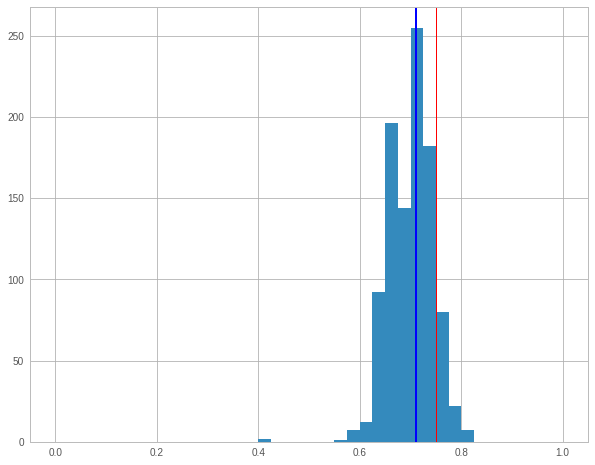

In [41]:
plt.figure(figsize=(10,8))
r = [0.0,1.0]
plt.hist([s for s in coin_bias_samples[coin_bias()][0]], bins=40, range=r)
plt.axvline(x=true_coin_bias, c='red', linewidth=1);
plt.axvline(x=coin_observed_rate, c='blue', linewidth=2);

The graph above is based on pseudo-randomly generated data, so, the results
can be varied by changing the seed. Typically, as is the case with the above run with a seed of 42, the true coin bias (the red line) will remain within the main non-zero probability part of the histogram, but may not necessarily fall in the modal interval of the histogram. More generally, for this particular problem, we can expect the mean of inferred distribution to always be closer to 0.5 than the true coin bias. This is because 0.5 is the mean of our prior for coin bias. This is a typical phenomena with Bayesian inference, where the result is influenced by both or prior and our data.

Bean Machine provides a Diagnostics package that provides helpful statistics about the result of the inference algorithm. We can query this information as follows: 

In [42]:
bm.Diagnostics(coin_bias_samples).summary([coin_bias()])

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
coin_bias()[],0.699273,0.045658,0.604758,0.705659,0.778719,1.000791,246.535706


As is suggested by the visualization, the average and the median are around 0.7. Moreover, 95% of the samples fall within the interval [0.6,0.78]. This confirms our impression that the true value (the red line) falls close to the upper edge of the main part of the support of this distribution.

The table also features two diagnostic statistics, namely, `r_hat` [1] and `n_eff` [2,3]. The first compares the chains that the inference algorithm has produced and computes a number in the interval [1,$\infty$]. Typically we consider inference to have converged to a satisfactory degree if `r_hat` is less than 1.1, which it is in this case. The second statistic, `n_eff`, is called the effective number. This number is always less than or equal to the actual sample size, and is an indicator of the amount of "information" in the sample.

Another set of useful tools for evaluating the quality of the infered distribution are the trace and autocorrelation plots. 
We can create them for the two chains generated above follows:

In [43]:
figs = bm.Diagnostics(coin_bias_samples).plot([coin_bias()])

for fig in figs:
    plotly.offline.iplot(fig)

The trace plot above suggests that both runs explore the part within the 95% confidence interval of the distribution quite well, and even slightly outside it as well. However, it does leave open the question of how well the area outside that range was covered. If we are concerned about getting better coverage for that area, we may wish to use more advanced features of the inference algorithms to cover those regions.

The autocorrelation plot gives us confidence that there is little periodicity within the results of each inference run. This gives us some assurance that the results of inference are free from obvious artefacts of the inference algorithm or the underlying random number generator.

This brings us to the conclusion of this tutorial. We hope that it provides the reader with a good starting point for using Bean Machine, especially in so far as illustrating the a common pattern for data scientists, namely, to define a model, to incorporate observed data, to run stastistical inference, and to analyize the resulting distribution. Happy inference!

## References

[1] Inference from iterative simulation using multiple sequences. A. Gelman and D. B. Rubin, Statistical Science, 7(4), 1992, pp. 457-472.

[2] Markov Chain Monte Carlo in Practice: A Roundtable Discussion. Robert E. Kass, Bradley P. Carlin, Andrew Gelman and Radford M. Neal. The American Statistician. Vol. 52, No. 2 (May, 1998), pp. 93-100

[3] Stochlastic Simulation, B. D. Ripley, 1987.